Comprehensive data exploration with Python \
(https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)

# 流れ
- 問題の理解 \
    変数の理解。重要度の理解
- ラベルの理解
- ラベルと変数の関係性の理解
- Cleaning

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 変数の理解
8１の変数の理解には時間がかかるが**ラベルの理解には必要**　\
Excel等にまとめる。 

    まとめかた
- 変数名
- Type: NumericalなのかCategoricalか 
- 区分: 今回は３つに分けられる。 \
    建物変数:　建物自体の特徴 \
空間変数: 広さや空間を表す特徴 \
立地変数: 建物の環境を表す特徴 \
- 予想: ラベルへの相関を'High', 'Medium', 'Low'と予想 \
    実際に家を購入する際にその変数を判断材料にするか? \
もしするなら、その影響どはどれほどのものか？ \
他変数とほとんど同じことを意味する変数があるか？
- 結果: 相関関係の結果

### 重要な変数の予想
- OverallQual: Rates the overall material and finish of the house
- YearBuilt: Original construction date
- TotalBsmtSF: Total square feet of basement area
- GrLivArea: Above grade (ground) living area square feet

>建物変数: OverallQual と YearBuilt \
空間変数: TotalBsmtSF と GrLivArea

## ラベルの理解 (SalePrice)

In [4]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

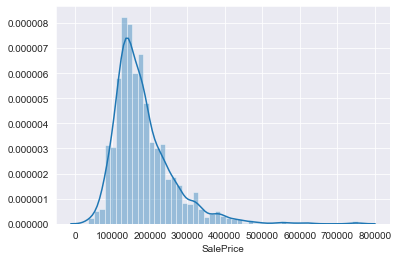

In [5]:
sns.distplot(df_train['SalePrice'])

In [6]:
df_train['SalePrice'].skew()

1.8828757597682129

In [7]:
df_train['SalePrice'].kurtosis()

6.536281860064529

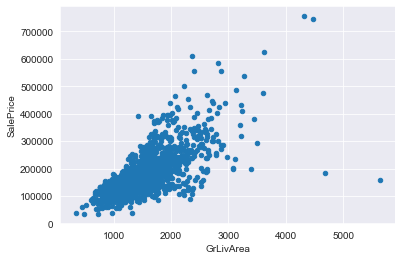

In [8]:
df_train[['GrLivArea', 'SalePrice']].plot.scatter(x='GrLivArea', y='SalePrice')

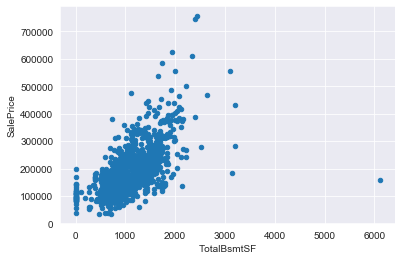

In [9]:
df_train[['TotalBsmtSF', 'SalePrice']].plot.scatter('TotalBsmtSF', 'SalePrice')

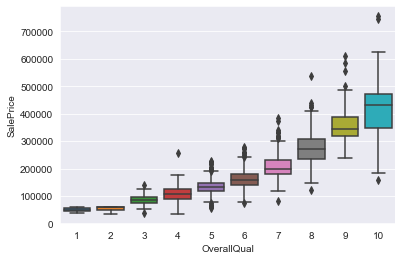

In [10]:
sns.boxplot(x='OverallQual', y='SalePrice', data=df_train)

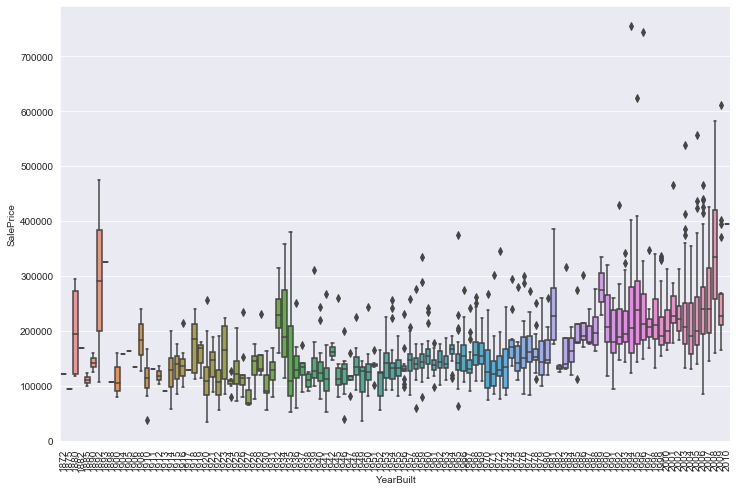

In [11]:
fig = plt.figure(figsize=(12, 8))
sns.boxplot('YearBuilt', 'SalePrice', data=df_train)
plt.xticks(rotation=90);

## 全体を見るために、SalePriceに対してCorrelation matrixの作成

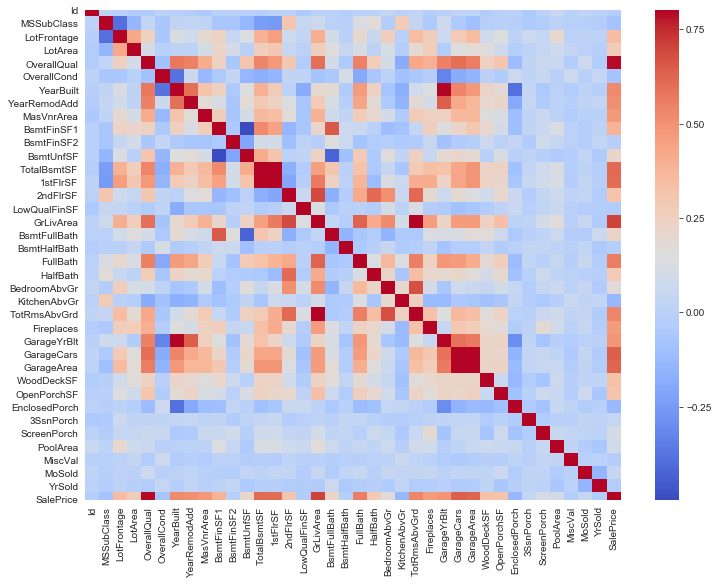

In [12]:
corrmat = df_train.corr()
plt.figure(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, cmap='coolwarm')

(10.0, 0.0)

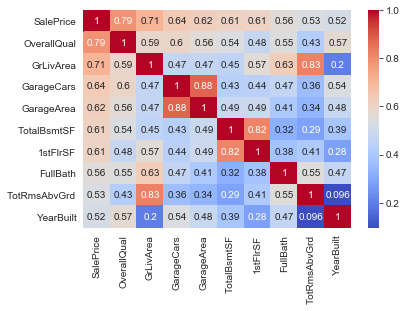

In [13]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice').index
cm = np.corrcoef(df_train[cols].values.T)

ax = sns.heatmap(cm, annot=True, fmt='.2g', yticklabels=cols.values, \
                        xticklabels=cols.values,cmap='coolwarm')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

- GarageCarsとGarageArea 
- TotalBsmtSFと1stFlrSF 
- TotRmsAbvGrdとGrLivArea

に相関が見えるためまとめる。

In [14]:
cols = cols.drop(['GarageArea', '1stFlrSF', 'TotRmsAbvGrd'])

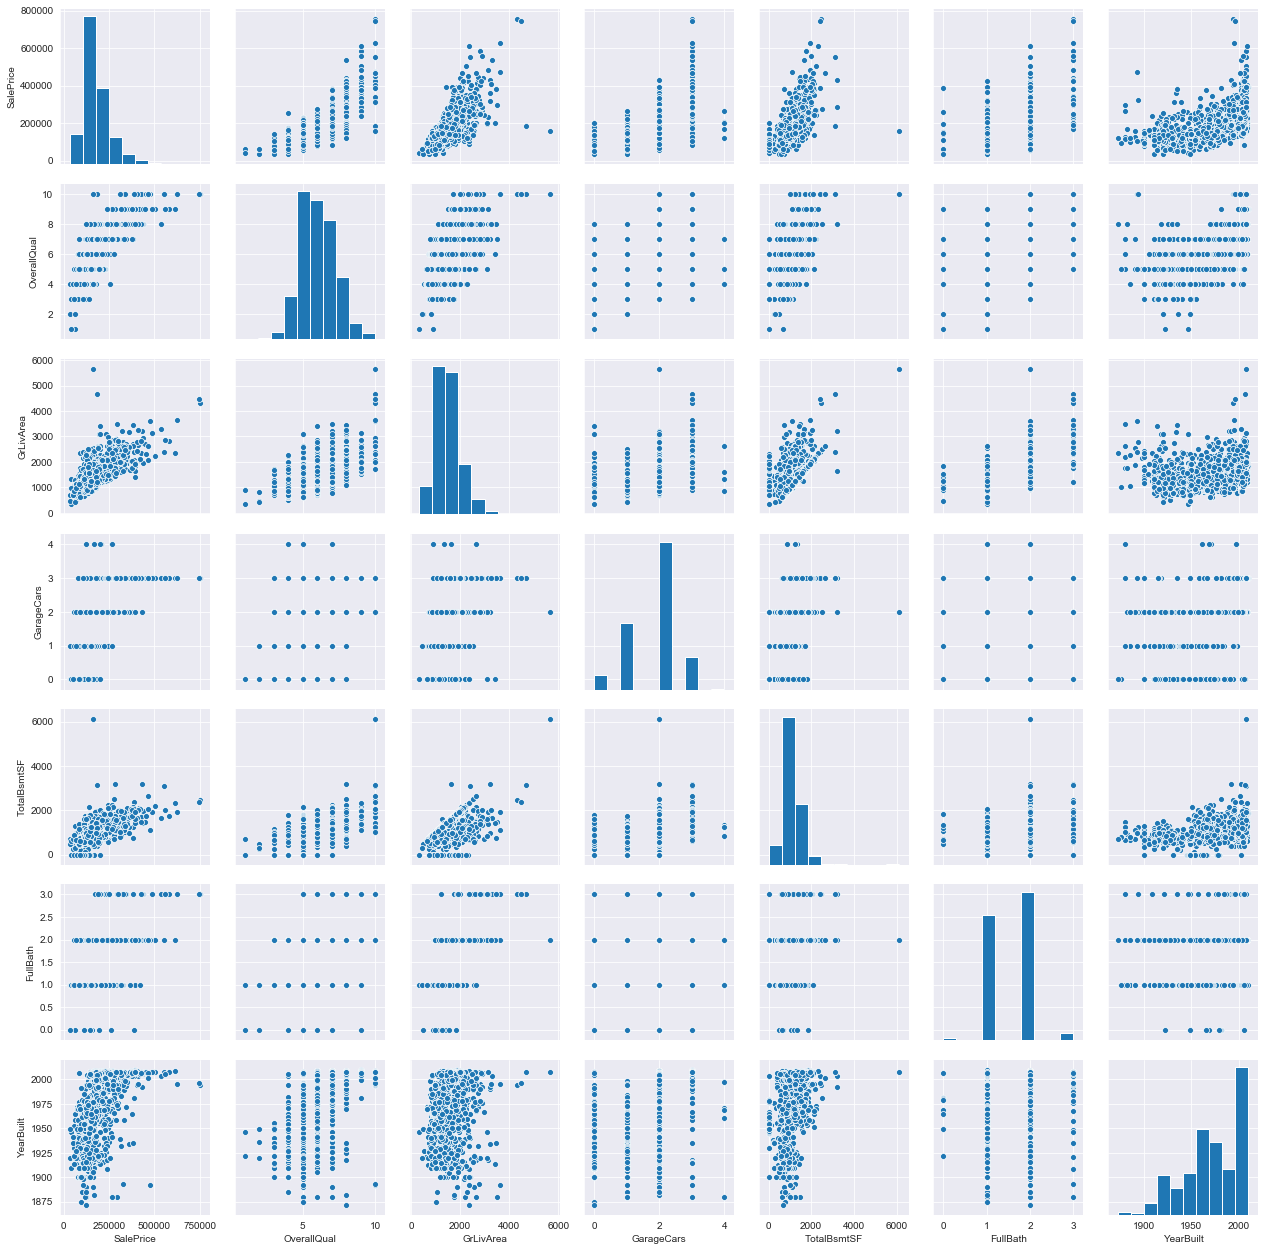

In [15]:
sns.pairplot(df_train[cols])

## 欠損値の確認

In [16]:
total_na = df_train.isna().sum()
percent = total_na / df_train.isna().count()
missing_data = pd.concat([total_na, percent], axis=1, keys=['Total', 'Percent']).sort_values(by='Percent', ascending=False)
missing_data[missing_data['Percent'] > 0]

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


> **.count()** ... Count non-NA cells for each column or row. \
df.isna().count()とすることでNAも数える。

欠損値の割合が15%以上の変数は削除。
データ数や影響度を考慮して決める。

In [17]:
df_train.drop(missing_data[missing_data['Percent'] >= 0.15].index, axis=1, inplace=True)

GarageXは全て同じ割合で欠損してあるので同一の物件と考えられる。 \
GarageCarsを採用するので他変数は削除できる。
BsmtXも同様に考える。

In [18]:
df_train.drop(['GarageYrBlt', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1'], axis=1, inplace=True)

### ※質問中 In[15]
Regarding 'MasVnrArea' and 'MasVnrType', we can consider that these variables are not essential. Furthermore, they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. Thus, we will not lose information if we delete 'MasVnrArea' and 'MasVnrType'.

(4.0, 0.0)

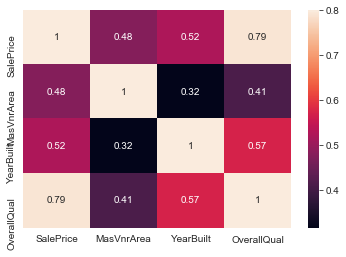

In [19]:
x = df_train[['SalePrice', 'MasVnrArea', 'MasVnrType', 'YearBuilt', 'OverallQual' ]].corr()
ax = sns.heatmap(x, annot=True, vmax=0.8)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [20]:
df_train.drop(['MasVnrArea', 'MasVnrType'], axis=1, inplace=True)

Electicalは欠損値がひとつのみなので、その列だけを削除

In [21]:
df_train.drop(df_train[df_train['Electrical'].isna()].index, axis=0, inplace=True)

## standardization outliers

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

>**np.newaxis**... \
.fit()はSeriesでerrorが起きるため (.fit(Series) ) \
.fit(Series[:, np.newaxis])とすることで1次元増やせる。 \
df_train['SalePrice].shape ... (1459,) \
df_train['SalePrice][:, newaxis].shape ... (1459, 1)

In [23]:
saleprice_scaled = scaler.fit_transform(df_train['SalePrice'][:, np.newaxis])

low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]

print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


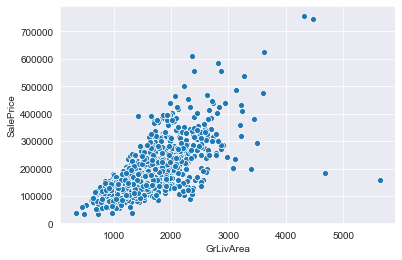

In [24]:
sns.scatterplot('GrLivArea', 'SalePrice', data=df_train)

In [25]:
df_train.drop(df_train['GrLivArea'].sort_values(ascending=False)[:2].index, inplace=True)

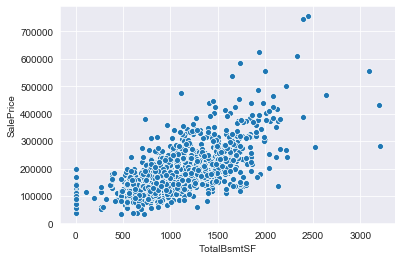

In [26]:
sns.scatterplot('TotalBsmtSF', 'SalePrice', data=df_train)

## ※以下は専門的な統計学の話になる。

4つの考え方。
- **Normality** \
= 正規分布。\
正規分布にすることで色々と問題を排除できる。
- **Homoscedasticity ?** \
we want the error term to be the same across all values of the independent variables.
- **Linearity** 
- **Absence of correlated errors** \
For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables.

In [27]:
from scipy.stats import norm 
from scipy import stats

### Noramlityの確認

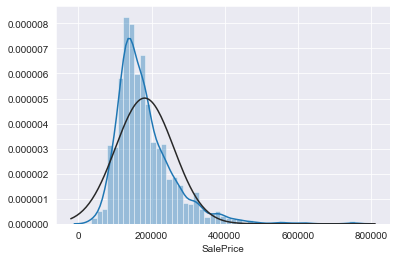

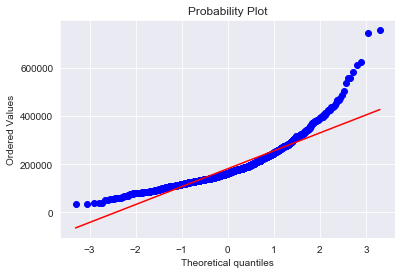

In [28]:
sns.distplot(df_train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [29]:
df_train['logSalePrice'] = np.log(df_train['SalePrice'])

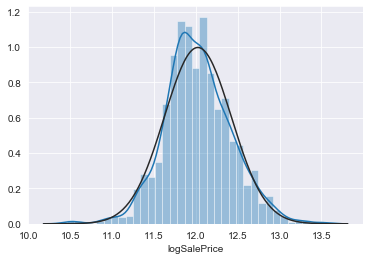

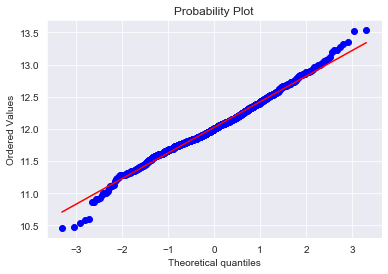

In [30]:
sns.distplot(df_train['logSalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['logSalePrice'], plot=plt)

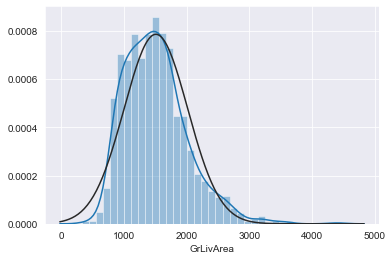

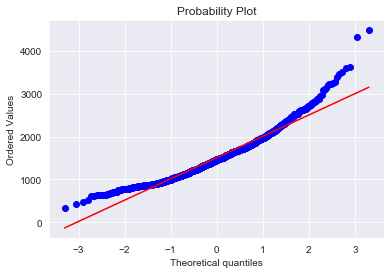

In [31]:
sns.distplot(df_train['GrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

In [32]:
df_train['logGrLivArea'] = np.log(df_train['GrLivArea'])

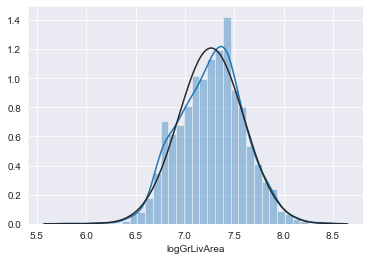

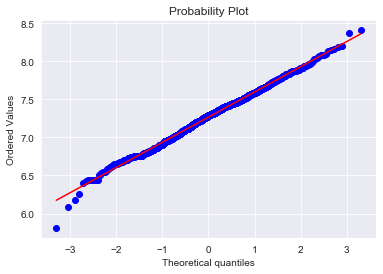

In [33]:
sns.distplot(df_train['logGrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['logGrLivArea'], plot=plt)

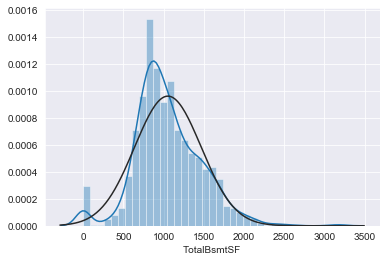

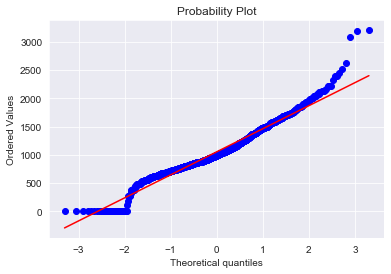

In [34]:
sns.distplot(df_train['TotalBsmtSF'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

In [35]:
def logBsmt(num):
    if num == 0:
        return 0
    else:
        return np.log(num)
    
df_train['logTotalBsmtSF'] = df_train['TotalBsmtSF'].apply(logBsmt)

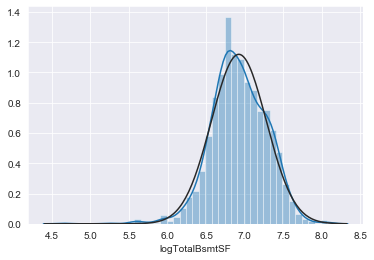

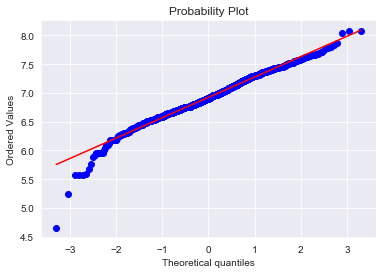

In [36]:
sns.distplot(df_train[df_train['logTotalBsmtSF']>0]['logTotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['logTotalBsmtSF']>0]['logTotalBsmtSF'], plot=plt)

正規化することで円錐形が改善 \
homoscedasticity problemを解決 (?)

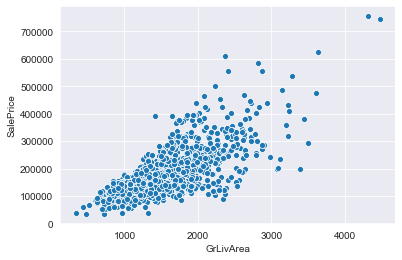

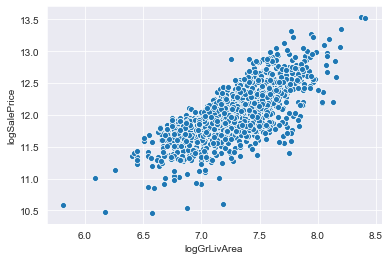

In [37]:
plt.figure()
sns.scatterplot('GrLivArea', 'SalePrice', data=df_train)

plt.figure()
sns.scatterplot('logGrLivArea', 'logSalePrice', data=df_train)

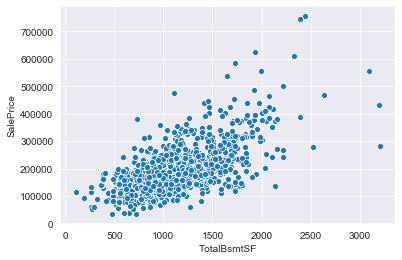

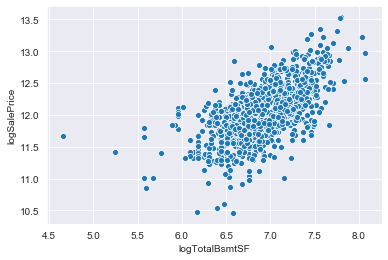

In [38]:
plt.figure()
sns.scatterplot(df_train.loc[df_train['TotalBsmtSF'] > 0, 'TotalBsmtSF'],
                df_train.loc[df_train['TotalBsmtSF'] > 0, 'SalePrice'])

plt.figure()
sns.scatterplot(df_train.loc[df_train['logTotalBsmtSF'] > 0, 'logTotalBsmtSF'],
                df_train.loc[df_train['logTotalBsmtSF'] > 0, 'logSalePrice'])

In [39]:
df_train = pd.get_dummies(df_train)